In [41]:
import pyspark as ps
import pandas as pd
import matplotlib.pyplot as plt
spark = (ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("nathanscope") 
        .getOrCreate()
        )

In [2]:
sc = spark.sparkContext

In [3]:
def auth_casting_function(row):
    (time, scr_user, dst_user, src_comp, dst_comp, auth_type,logon_type,auth_orientation,success) = row
    feilds = [time, scr_user, dst_user, src_comp, dst_comp, auth_type,logon_type,auth_orientation,success]
    
    print('success')
    if(time=='?'):
        time = 666999666
    return (int(time),scr_user, dst_user, src_comp, dst_comp, auth_type,logon_type,auth_orientation,success)

In [4]:
def proc_casting_function(row):
    (time,user_domain,comp,proc_name,start) = row
    if(time=='?'):
        time = 666999666
    return (int(time),user_domain,comp,proc_name,start)

In [5]:
def flow_casting_function(row):
    (time, duration,src_comp,src_port,dst_comp,dst_port,protocol,pk_count,byte_count) = row
    if(time=='?'):
        time = 666999666
    return (int(time),int(duration),src_comp,src_port,dst_comp,dst_port,protocol,int(pk_count),int(byte_count))

In [6]:
def DNS_casting_function(row):
    (time, src_comp,comp_resolved) = row
    if(time=='?'):
        time = 666999666
    return (int(time),src_comp,comp_resolved)

In [7]:
# import the many data types
from pyspark.sql.types import *

# create a schema of your own
auth_schema = StructType( [
    StructField('time',     LongType(), True),
    StructField('src_user_domain',   StringType(),  True),
    StructField('dst_user_domain',   StringType(),  True),
    StructField('src_comp',   StringType(),  True),
    StructField('dst_comp',   StringType(),  True),
    StructField('auth_type',  StringType(), True),
    StructField('logon_type',  StringType(),  True),
    StructField('auth_orientation',  StringType(),  True),
    StructField('Success',  StringType(),  True)] )

proc_schema = StructType( [
    StructField('time',     LongType(), True),
    StructField('user_domain',   StringType(),  True),
    StructField('comp',   StringType(),  True),
    StructField('proc_name',   StringType(),  True),
    StructField('start',   StringType(),  True),
    ] )

flow_schema = StructType( [
    StructField('time',     LongType(), True),
    StructField('duration',     LongType(), True),
    StructField('src_comp',   StringType(),  True),
    StructField('src_port',   StringType(),  True),
    StructField('dst_comp',   StringType(),  True),
    StructField('dst_port',   StringType(),  True),
    StructField('protocol',  StringType(), True),
    StructField('pk_count',  LongType(),  True),
    StructField('byte_count',  LongType(),  True)] )

DNS_schema = StructType( [
    StructField('time',     LongType(), True),
    StructField('src_comp',   StringType(),  True),
    StructField('comp_resolved',   StringType(),  True),
    
    ] )

## Create RDDS from Text Input

rdd_auth = (sc.pickleFile("Data/Day1/auth/part*")
            
           )

rdd_proc = (sc.pickleFile("Data/Day1/proc/part*")
            
           )

rdd_flow = (sc.pickleFile('Data/Day1/flow/part*')
           )

rdd_DNS = (sc.pickleFile("Data/Day1/DNS/part*")
           
           )

## Create DataFrames from RDDs and 

In [8]:
auth_df = spark.createDataFrame(rdd_auth,auth_schema)

proc_df = spark.createDataFrame(rdd_proc,proc_schema)

flow_df = spark.createDataFrame(rdd_flow,flow_schema)

DNS_df = spark.createDataFrame(rdd_DNS,DNS_schema)

In [9]:
len_flow = rdd_flow.count()

In [10]:
len_flow

8366186

In [11]:
## Describe Data Sources and then save locally

auth_Describe = auth_df.describe().collect()

proc_Describe = proc_df.describe().collect()

flow_Describe = flow_df.describe().collect()

DNS_Describe = DNS_df.describe().collect()

flow_Describe

auth_desc_df = pd.DataFrame(auth_Describe)
auth_desc_df.columns = ['summary'] + auth_df.schema.names

proc_desc_df = pd.DataFrame(proc_Describe)
proc_desc_df.columns = ['summary'] + proc_df.schema.names

flow_desc_df = pd.DataFrame(flow_Describe)
flow_desc_df.columns = ['summary'] + flow_df.schema.names

DNS_desc_df = pd.DataFrame(DNS_Describe)
DNS_desc_df.columns = ['summary'] + DNS_df.schema.names

auth_desc_df.to_csv('Summary/Day1/auth.csv')
proc_desc_df.to_csv('Summary/Day1/proc.csv')
flow_desc_df.to_csv('Summary/Day1/flow.csv')
DNS_desc_df.to_csv('Summary/Day1/DNS.csv')

In [12]:
flow_df.show(20)

+-----+--------+--------+--------+--------+--------+--------+--------+----------+
| time|duration|src_comp|src_port|dst_comp|dst_port|protocol|pk_count|byte_count|
+-----+--------+--------+--------+--------+--------+--------+--------+----------+
|47737|       0|  C24025|   N9773|   C1707|    N368|       6|       8|      1346|
|47737|       0|   C2614|   N7656|    C585|     139|       6|       2|        94|
|47737|       0|   C2852|   N3047|   C5030|     443|       6|       2|        92|
|47737|       0|   C2908|    N217|    C467|    N218|       1|       1|        60|
|47737|       0|   C3623|   N3257|    C706|      80|       6|       8|      3632|
|47737|       0|    C366|     445|  C13923|   N4402|       6|       1|        46|
|47737|       0|    C467|    N218|   C2908|    N218|       1|       1|        60|
|47737|       0|   C5030|     443|   C2852|   N3047|       6|       1|        46|
|47737|       0|    C528|     123|   C4230|     123|      17|       1|        96|
|47737|       0|

## Add Interval Column

In [13]:
#divide data frame into increments of 10 minutes
interval_size = 600

In [14]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

In [21]:
make_interval = udf(lambda x :  str((x//interval_size)*interval_size).zfill(7))

In [22]:
flow_time_df = flow_df.withColumn('interval', make_interval(flow_df['time']))


In [23]:
flow_time_df.show()

+-----+--------+--------+--------+--------+--------+--------+--------+----------+--------+
| time|duration|src_comp|src_port|dst_comp|dst_port|protocol|pk_count|byte_count|interval|
+-----+--------+--------+--------+--------+--------+--------+--------+----------+--------+
|47737|       0|  C24025|   N9773|   C1707|    N368|       6|       8|      1346| 0047400|
|47737|       0|   C2614|   N7656|    C585|     139|       6|       2|        94| 0047400|
|47737|       0|   C2852|   N3047|   C5030|     443|       6|       2|        92| 0047400|
|47737|       0|   C2908|    N217|    C467|    N218|       1|       1|        60| 0047400|
|47737|       0|   C3623|   N3257|    C706|      80|       6|       8|      3632| 0047400|
|47737|       0|    C366|     445|  C13923|   N4402|       6|       1|        46| 0047400|
|47737|       0|    C467|    N218|   C2908|    N218|       1|       1|        60| 0047400|
|47737|       0|   C5030|     443|   C2852|   N3047|       6|       1|        46| 0047400|

In [32]:
flow_time_series = flow_time_df.groupBy('interval').agg({'duration': 'mean','pk_count':'sum','byte_count':'sum'}).collect()




In [31]:
len(flow_time_series)

144

In [38]:
flow_time_series_df = pd.DataFrame(flow_time_series)
flow_time_series_df.columns = ['interval','duration','pk_count','byte_count']

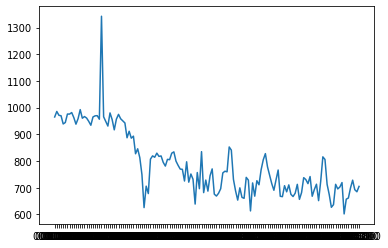

In [45]:
flow_time_series_df = flow_time_series_df.sort_values(['interval'])
plt.plot(flow_time_series_df['interval'],flow_time_series_df['byte_count']/flow_time_series_df['pk_count'])


In [ ]:
from pyspark.sql.functions import lit

flow_time_df = flow_df.withColumn("interval",lit(flow_df.rdd.map(lambda x: str((x.time//interval_size)*interval_size).zfill(12)).collect()) )

In [ ]:
flow_time_df.show()